## 2xLSTM

Extracting GloVe...
GloVe ready!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 30, 100)        │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 32)             │            62 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,023 (957.12 KB)

 Trainable params: 45,023 (175.87 KB)

 Non-trainable params: 200,000 (781.25 KB)

Epoch 1/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5511 - loss: 0.8957 — train_f1: 0.6811 — val_f1: 0.6667
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.5509 - loss: 0.8957 - val_accuracy: 0.5400 - val_loss: 0.8972 - learning_rate: 5.0000e-05
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5148 - loss: 0.8949 — train_f1: 0.6847 — val_f1: 0.6618
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.5148 - loss: 0.8949 - val_accuracy: 0.5400 - val_loss: 0.8928 - learning_rate: 5.0000e-05
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5200 - loss: 0.8924 — train_f1: 0.6837 — val_f1: 0.6617
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 379ms/step - accuracy: 0.5204 - loss: 0.8924 - val_accuracy: 0.5450 - val_loss: 0.8886 - learning_rate: 5.0000e-05
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5235 - loss: 0.8894 — train_f1: 0.6835 — val_f1: 0.6718
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.5237 - loss: 0

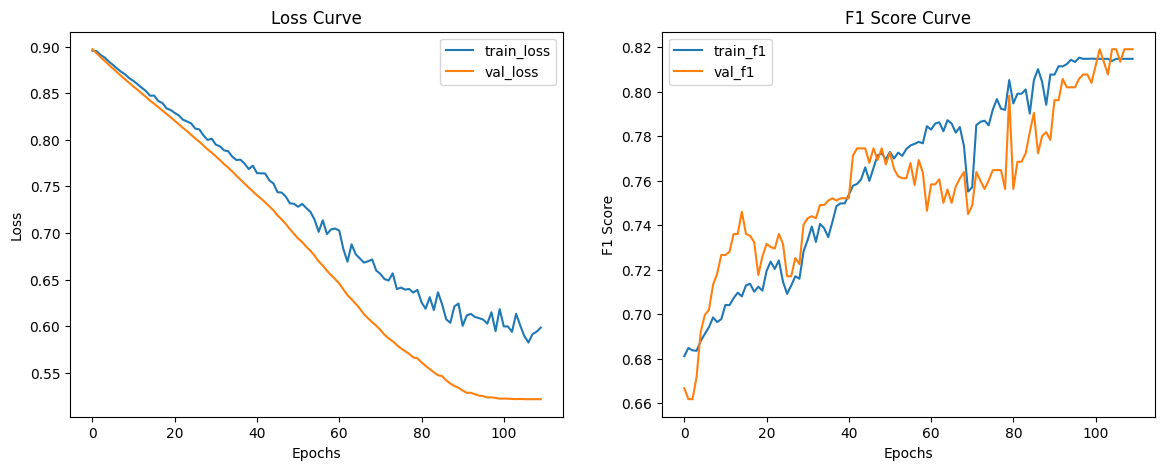

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
              precision    recall  f1-score   support

           0     0.8352    0.7600    0.7958       100
           1     0.7798    0.8500    0.8134       100

    accuracy                         0.8050       200
   macro avg     0.8075    0.8050    0.8046       200
weighted avg     0.8075    0.8050    0.8046       200



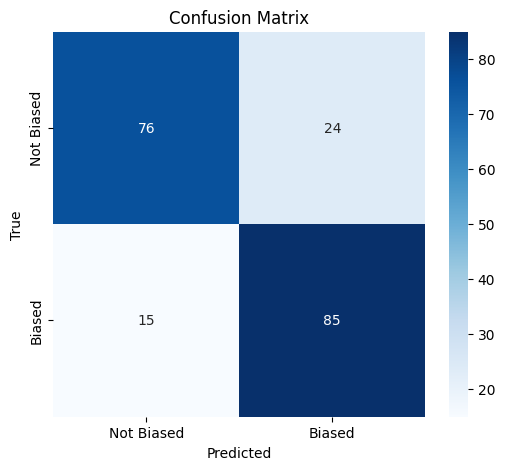

In [ ]:
# ===== 0. Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os, requests, zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# ===== 1. Download GloVe (100d) =====
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (~822MB zip)...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url, stream=True)
    with open("glove.6B.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Extracting GloVe...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    print("GloVe ready!")

# ===== 2. Load Dataset =====
data = pd.read_csv("balanced_dataset.csv")  # must exist in Colab
labels = data['isBiased'].values.astype(int).reshape(-1,1)

# ===== 3. Preprocessing =====
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in data['title'].astype(str)]

# ===== 4. Tokenization =====
max_words = 2000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 5. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 6. Load GloVe Embeddings =====
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

# ===== 7. F1 Callback =====
class F1Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = (self.model.predict(X_train, verbose=0) > 0.5).astype(int)
        y_val_pred = (self.model.predict(X_val, verbose=0) > 0.5).astype(int)
        self.train_f1s.append(f1_score(y_train, y_train_pred))
        self.val_f1s.append(f1_score(y_val, y_val_pred))
        print(f" — train_f1: {self.train_f1s[-1]:.4f} — val_f1: {self.val_f1s[-1]:.4f}")

f1_callback = F1Metrics()

# ===== 8. Custom Attention Layer =====
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1),
            initializer="glorot_uniform", trainable=True
        )
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1),
            initializer="zeros", trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = x * alpha
        return K.sum(context, axis=1)

# ===== 9. Build Double BiLSTM + Attention Model =====
def build_double_bilstm_attention(max_words, embedding_dim, max_len, embedding_matrix):
    inputs = Input(shape=(max_len,))

    x = Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False   # freeze embeddings to reduce overfitting
    )(inputs)

    # First BiLSTM
    x = Bidirectional(LSTM(
        32, return_sequences=True,
        dropout=0.4, recurrent_dropout=0.3
    ))(x)

    # Second BiLSTM
    x = Bidirectional(LSTM(
        16, return_sequences=True,
        dropout=0.3, recurrent_dropout=0.2
    ))(x)

    # Attention
    x = Attention()(x)

    # Dense + Dropout
    x = Dense(16, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.4)(x)

    # Output
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=5e-5, clipnorm=1.0)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

model = build_double_bilstm_attention(max_words, embedding_dim, max_len, embedding_matrix)
model.summary()

# ===== 10. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

# ===== 11. Training =====
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, f1_callback],
    verbose=1
)

# ===== 12. Plot Loss & F1 =====
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_callback.train_f1s, label='train_f1')
plt.plot(f1_callback.val_f1s, label='val_f1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# ===== 13. Evaluation =====
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased','Biased'],
            yticklabels=['Not Biased','Biased'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
